In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/pyTracker/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/pyTracker/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import datatypes
from datatypes import *

reload(TF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/pyTracker/tracker/utilities.py'>

### Defining Useful Functions ### 

In [4]:
steel_height=3 # cm
Box_IP_Depth=8547 # cm   

wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [57]:
def SortByTime(points):
    """
    Sorts list hits by time
    A hit is of the form (x,y,z,t)
    """
    if len(points) <= 1:
        return points
    pivot = points[len(points) // 2]
    left = []
    middle = []
    right = []
    for point in points:
        if point[-1] < pivot[-1]:
            left.append(point)
        elif point[-1] > pivot[-1]:
            right.append(point)
        elif point[-1] == pivot[-1]:
            middle.append(point)
    return SortByTime(left) + middle + SortByTime(right)


def ProjectionTime(track, points, layer):
    """
    Takes a track and its SORTED list of points
    closest is true if you want to check in the closest wall/floor,
    false if you wanna check in the farther wall/floor
    Returns the time at which the track is 
    projected to enter the wall or floor
    Given point is (x,y,z,t)
    """
    if layer == 0:# Walls
        if track.Ay == 1: # Horizontal layer track 
            return track.At/track.Az*(wallMid1 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid1 - points[0][2]) + points[0][3]
    elif layer == 1:
        if track.Ay == 1: # Horizontal layer track
            return track.At/track.Az*(wallMid2 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid2 - points[0][2]) + points[0][3]
    elif layer == 2: # Floors
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid1 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid1 - points[0][1]) + points[0][3]
    elif layer == 3: 
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid2 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid2 - points[0][1]) + points[0][3]


def ProjectionPoint(track, points, t):
    """
    Returns where the track is projected to be at time t.
    points is the list of hits from the track sorted by time
    Returns an empty array if out of the detector
    """
    if track.Ay == 1: #Horizontal layer track
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + 1/track.At * (t - points[0][3])
        zf = points[0][2] + track.Az/track.At*(t - points[0][3])
    else: # Vertical layer track 
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + track.Ay/track.At * (t - points[0][3])
        zf = points[0][2] + 1/track.At*(t - points[0][3])
    return np.array((xf,yf,zf))


def GetDistance(point1, point2):
    """
    Get the distance between two points (x,y,z)
    """
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)


def Ellipse(x, y, c1, c2, a, b):
    """
    Returns whether (x,y) lies within the ellipse
    """
    return (x-c1)**2/a**2 + (y-c2)**2/b**2


def ConvertVelocity(track):
    """
    Converts the velocity from either dk/dy or dk/dz
    to dk/dt
    """
    if track.Ay == 1: # Horizontal layer track
        A_1x = track.Ax/track.At; A_1y = 1/track.At; A_1z = track.Az/track.At
    else: # Vertical layer track
        A_1x = track.Ax/track.At; A_1y = track.Ay/track.At; A_1z = 1/track.At
    return np.array((A_1x, A_1y, A_1z))


def MaxTracks(vertex, tracks):
    """
    Get the track indices that have the largest angle of separation
    """
    inds = None
    min_angle = None
    for i in range(len(vertex.tracks)):
        ind_1 = vertex.tracks[i]
        t1 = tracks[ind_1]
        A1 = ConvertVelocity(t1)
        for j in range(i + 1, len(vertex.tracks)):
            ind_2 = vertex.tracks[j]
            t2 = tracks[ind_2]
            A2 = ConvertVelocity(t2)
            angle = np.arccos(np.dot(A1, A2)/(np.linalg.norm(A1)*np.linalg.norm(A2)))
            if min_angle is None or angle < min_angle:
                min_angle = angle
                inds = (ind_1, ind_2)
    return inds


def ClosestApproach(point, track):
    """
    Gets the point at which the track is closest to point
    """
    A = ConvertVelocity(track)
    P_0 = np.array((track.x0, track.y0, track.z0))
    t_c = np.dot((point - P_0), A)/np.linalg.norm(A)**2 + track.t0
    return P_0 + A*(t_c - track.t0)


def EllipseAngle(p1, p2):
    """
    Get the angle of the ellipse. This is always with 
    respect to the x axis
    """
    if p1[1] - p2[1] < 0.001: # Floor
        dz = p2[2] - p1[2]; dx = p2[0] - p1[0]
        slope = dz/dx
        angle = np.arctan(dz/dx)
    else: # Wall
        dy = p2[1] - p1[1]; dx = p2[0] - p1[0]
        slope = dy/dx
        angle = np.arctan(dy/dx)        
    return angle
        

def GetEllipse(vertex, tracks, layer):
    """
    Gets the center of the backwards cone of the vertex
    """
    
    ind_1, ind_2 = MaxTracks(vertex, tracks)
    t1 = tracks[ind_1]; t2 = tracks[ind_2]
    t1Points = SortByTime(t1.hits_filtered); t2Points = SortByTime(t2.hits_filtered)
    time1 = ProjectionTime(t1, t1Points, layer); time2 = ProjectionTime(t2, t2Points, layer)
    p1 = ProjectionPoint(t1, t1Points, time1); p2 = ProjectionPoint(t2, t2Points, time2)
    midpoint = (p1 + p2)/2
    c1 = midpoint[0]
    if layer < 2: # Wall
        c2 = midpoint[1]
        a = GetDistance(p1, midpoint) # Axis 1
        b = GetDistance(ClosestApproach(midpoint, t1), midpoint) # Axis 2
        angle = EllipseAngle(p1, p2)
        def Ellipse(x, y):
            """
            Returns whether (x,y) lies within the ellipse
            """
            x_p = (x-c1)*np.cos(angle) + (y-c2)*np.sin(angle)
            y_p = (y-c2)*np.cos(angle) - (x-c1)*np.sin(angle)
            return ((x_p)**2/a**2 + (y_p)**2/b**2) <= 1
    else: # Floor
        c2 = midpoint[2]
        a = GetDistance(p1, midpoint) # Axis 1
        b = GetDistance(ClosestApproach(midpoint, t1), midpoint) # Axis 2
        angle = EllipseAngle(p1, p2)
        def Ellipse(x, z):
            """
            Returns whether (x,z) lies within the ellipse
            """
            x_p = (x-c1)*np.cos(angle) + (z-c2)*np.sin(angle)
            z_p = (z-c2)*np.cos(angle) - (x-c1)*np.sin(angle)
            return ((x_p)**2/a**2 + (z_p)**2/b**2) <= 1
    return Ellipse
        
def Ellipses(vertex, tracks):
    """
    Gets the Ellipses for each layer
    """
    ells = []
    for i in range(len(y_bottoms) + len(z_fronts)):
        ells.append(GetEllipse(vertex,tracks,i))
    return ells


def EllipseEquation(vertex, tracks, layer):
    """
    Gets the center of the backwards cone of the vertex
    """
    
    ind_1, ind_2 = MaxTracks(vertex, tracks)
    t1 = tracks[ind_1]; t2 = tracks[ind_2]
    t1Points = SortByTime(t1.hits_filtered); t2Points = SortByTime(t2.hits_filtered)
    time1 = ProjectionTime(t1, t1Points, layer); time2 = ProjectionTime(t2, t2Points, layer)
    p1 = ProjectionPoint(t1, t1Points, time1); p2 = ProjectionPoint(t2, t2Points, time2)
    midpoint = (p1 + p2)/2
    c1 = midpoint[0]
    if layer < 2: # Wall
        c2 = midpoint[1]
        a = GetDistance(p1, midpoint) # Axis 1
        b = GetDistance(ClosestApproach(midpoint, t1), midpoint) # Axis 2
        angle = EllipseAngle(p1, p2)
        def Ellipse(t):
            """
            Returns whether (x,y) lies within the ellipse
            """
            x = a*np.cos(t) + c1; y = b*np.sin(t) + c2
            x_p = (x-c1)*np.cos(angle) - (y-c2)*np.sin(angle) + c1
            y_p = (y-c2)*np.cos(angle) + (x-c1)*np.sin(angle) + c2
            return np.array((x_p, y_p))
    else: # Floor
        c2 = midpoint[2]
        a = GetDistance(p1, midpoint) # Axis 1
        b = GetDistance(ClosestApproach(midpoint, t1), midpoint) # Axis 2
        angle = EllipseAngle(p1, p2)
        def Ellipse(t):
            """
            Returns whether (x,y) lies within the ellipse
            """
            x = a*np.cos(t) + c1; y = b*np.sin(t) + c2
            x_p = (x-c1)*np.cos(angle) - (y-c2)*np.sin(angle) + c1
            y_p = (y-c2)*np.cos(angle) + (x-c1)*np.sin(angle) + c2
            return np.array((x_p, y_p))
    return Ellipse


In [58]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

98


### Checking Individual Track ###

index: 45
[[-416.76364135496203, 9975.6, 9582.205443812043, 463.0310917462427], [-414.53588264422694, 10057.2, 9681.681246601707, 468.70652387638273], [-412.2625283181385, 10138.8, 9781.076078785858, 474.37974702920576]]


NameError: name 'GoingUp' is not defined

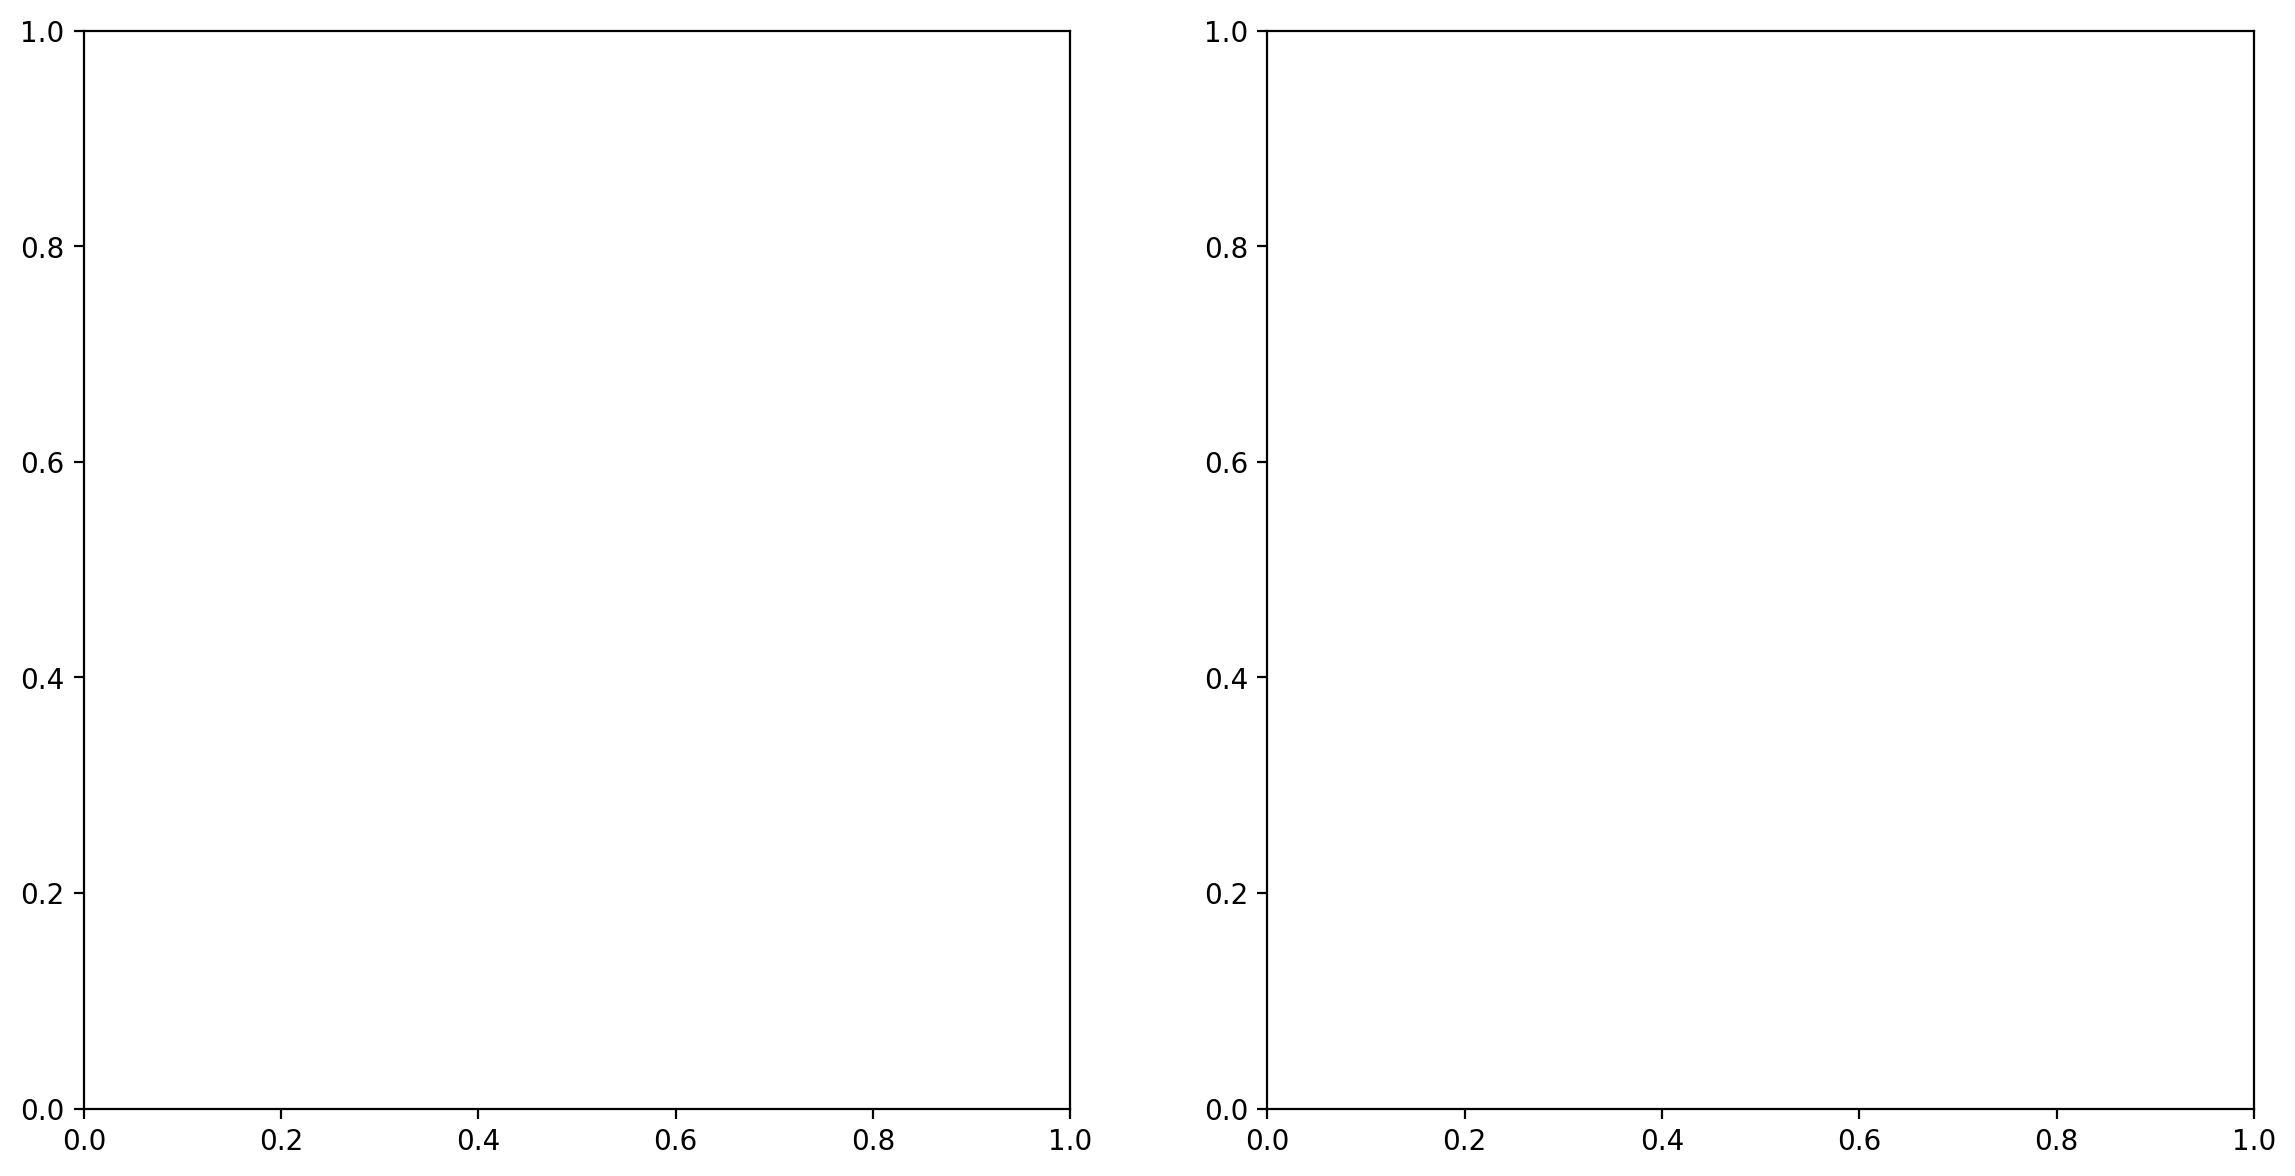

In [59]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

events=joblib.load(pathList[0])
file_hits = events["hits"]
file_tracks = events["tracks"]
file_vertices = events["vertices"]
i = 25
searching = True
while searching:
    i+= 1
    hits= file_hits[i]
    tracks = file_tracks[i]
    vertices = file_vertices[i]
    if len(tracks) < 2:
        continue
    break
    # for track in tracks:
    #     if track.Az == 1:
    #         searching = False
    #         break
print("index:", i)
wf_hits = []
# noVerticals = True
# for track in tracks:
#     if track.Az == 1:
#         noVerticals = False
# if noVerticals:
#     continue
for hit in hits:
    if hit.layer < 4:
        wf_hits.append(hit)
for track in tracks:
#     if track.Az != 1:
#         continue
    trackPoints = SortByTime(track.hits_filtered)
    print(trackPoints)
    if not GoingUp(trackPoints):
        print("not going up")
        continue
    chi2 = 9999999999999
    min_hit = None
    min_point = None
    for hit in wf_hits:
        curr_chi2 = GetChiSquared(hit, track)
        if curr_chi2 is not None and curr_chi2 < chi2:
            chi2 = curr_chi2
            min_hit = hit
            min_time = ProjectionTime(track, trackPoints, hit.layer)
            min_point = ProjectionPoint(track, trackPoints, min_time)
    print("chi2:", chi2)
    if min_point is None:
        continue
    x,y,z = np.array(track.hits_filtered).T[:3]
    x = np.append(x, min_point[0])
    y = np.append(y, min_point[1])
    z = np.append(z, min_point[2])
    x_h,y_h,z_h = np.array([min_hit.x, min_hit.y, min_hit.z])
    print(x_h, y_h, z_h)
    axs[0].scatter(z_h, y_h, marker="*", label="True hit")
    axs[0].plot(z,y, marker="1", label="Track")
    axs[1].scatter(x_h, y_h, marker="*", label="True hit")
    axs[1].plot(x,y,marker="1", label="Track")
    axs[0].legend()
    axs[1].legend()
# plt.legend()

index: 65
P1 [-1675.51807409  8632.4         7742.70538961]
P2 [-1751.08079571  8632.4         8178.3245424 ]
P1 [-217.09124561 8550.8        6687.12303042]
P2 [-1515.2821493   8550.8         7732.40714934]
P1 [-1502.88793983  8632.4         7314.61535442]
P2 [-1174.84391749  8632.4         7881.73007713]


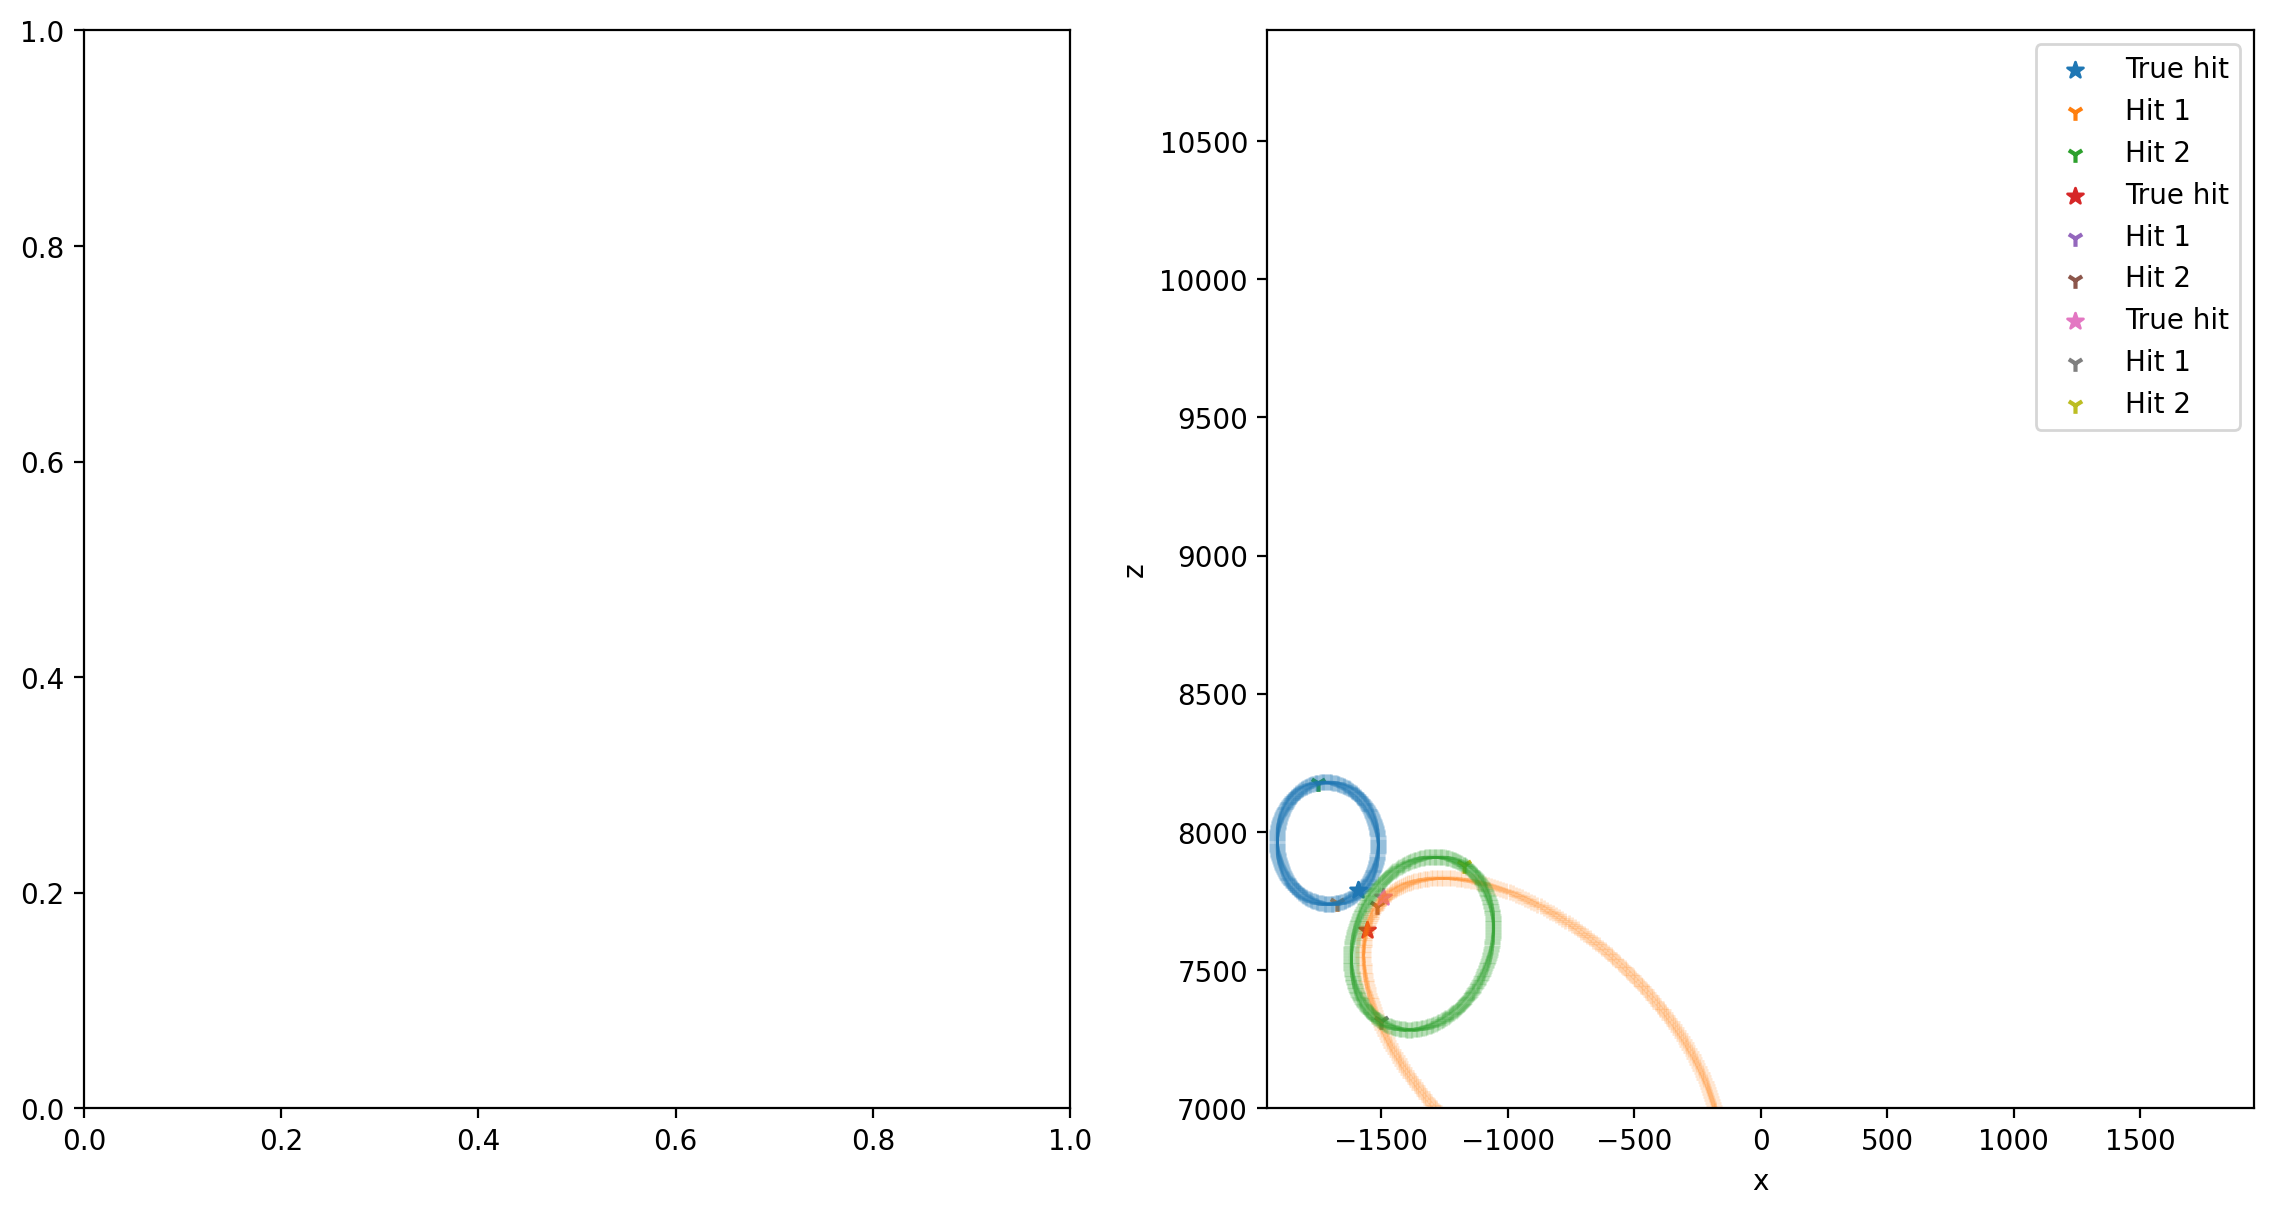

In [61]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

events=joblib.load(pathList[3])
file_hits = events["hits"]
file_tracks = events["tracks"]
file_vertices = events["vertices"]
i = 26
searching = True
while searching:
    i+= 1
    hits= file_hits[i]
    tracks = file_tracks[i]
    vertices = file_vertices[i]
    if len(vertices) < 1:
        continue
    break
print("index:", i)
wf_hits = []
for hit in hits:
    if hit.layer < 4:
        wf_hits.append(hit)
for vertex in vertices:
    layer_ells = Ellipses(vertex, tracks)
    for hit in wf_hits:
        layer = hit.layer
        if hit.layer < 2 and layer_ells[layer](hit.x, hit.y): # Wall
            ind_1, ind_2 = MaxTracks(vertex, tracks)
            t1 = tracks[ind_1]; t2 = tracks[ind_2]
            t1Points = SortByTime(t1.hits_filtered); t2Points = SortByTime(t2.hits_filtered)
            time1 = ProjectionTime(t1, t1Points, layer); time2 = ProjectionTime(t2, t2Points, layer)
            p1 = ProjectionPoint(t1, t1Points, time1); p2 = ProjectionPoint(t2, t2Points, time2)
            ell_eq = EllipseEquation(vertex, tracks,layer)
            degs = np.linspace(0, 360, 360)
            x,y = ell_eq(degs)
            x_h,y_h,z_h = np.array([hit.x, hit.y, hit.z])
            axs[0].scatter(x_h, y_h, marker="*", label="True hit")
            axs[0].scatter(p1[0], p1[1], marker="1", label="Hit 1")
            axs[0].scatter(p2[0], p2[1], marker="1", label="Hit 2")
            axs[0].plot(x,y, marker="+", alpha=0.2)
            axs[0].set_xlabel("x")
            axs[0].set_ylabel("y")
            axs[0].set_xlim([-1950, 1950])
            axs[0].set_ylim([8550, 9893.2])
            axs[0].legend()
            break
        elif layer_ells[layer](hit.x,hit.z): # Floor
            ind_1, ind_2 = MaxTracks(vertex, tracks)
            t1 = tracks[ind_1]; t2 = tracks[ind_2]
            t1Points = SortByTime(t1.hits_filtered); t2Points = SortByTime(t2.hits_filtered)
            time1 = ProjectionTime(t1, t1Points, layer); time2 = ProjectionTime(t2, t2Points, layer)
            p1 = ProjectionPoint(t1, t1Points, time1); p2 = ProjectionPoint(t2, t2Points, time2)
            print("P1", p1)
            print("P2", p2)
            ell_eq = EllipseEquation(vertex, tracks,layer)
            degs = np.linspace(0, 2*np.pi, 360)
            x,z = ell_eq(degs)
            x_h,y_h,z_h = np.array([hit.x, hit.y, hit.z])
            axs[1].scatter(x_h, z_h, marker="*", label="True hit")
            axs[1].plot(x,z, marker="+", alpha=0.2)
            axs[1].scatter(p1[0], p1[2], marker="1", label="Hit 1")
            axs[1].scatter(p2[0], p2[2], marker="1", label="Hit 2")
            axs[1].set_xlabel("x")
            axs[1].set_ylabel("z")
            axs[1].set_xlim([-1950, 1950])
            axs[1].set_ylim([7000, 10900])
            axs[1].legend()
            break
